In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
from time import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
pd.set_option("display.max_columns", 30)
from collections import Counter
# Library's to apply balance technic's
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from utils import create_variables,delete_outliers,scale_data,get_na,plot_pie

In [2]:
start_notebook = time()

In [3]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
df = delete_outliers(df)
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
Airport Name,64852,3233,4.75
IATA Code,68079,6,0.01
Fecha-I,68085,0,0.00
Vlo-I,68085,0,0.00
City/Town,68085,0,0.00
...,...,...,...
TIPOVUELO,68085,0,0.00
OPERA,68085,0,0.00
SIGLAORI,68085,0,0.00
SIGLADES,68085,0,0.00


Información del dataset:
 las clases del target son: Counter({0: 38868, 1: 8791})


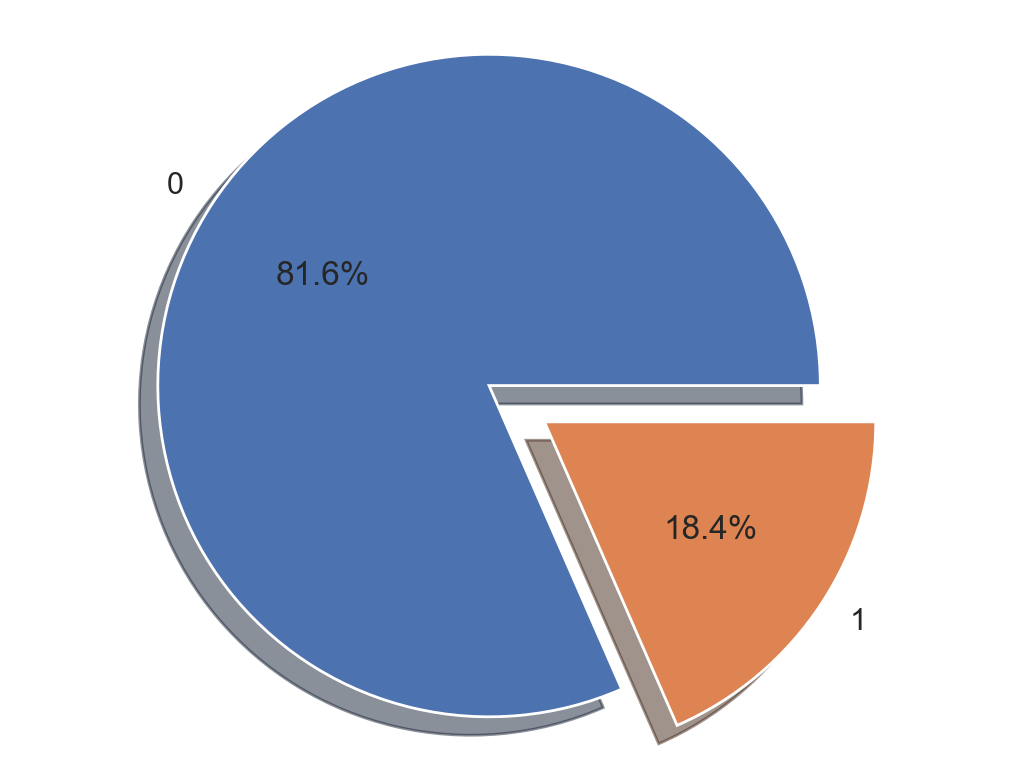

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=100)
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [5]:
col_to_drop = ['Fecha-O','Fecha-I','fecha_operacion','DIA','AÑO','Des-I','Vlo-I','Vlo-O','Ori-O','Ori-I','Des-I','Des-O','OPERA','Emp-I','Emp-O',
                'IATA Code','Airport Name','Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
                'temporada_alta','NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O','Emp-Vlo-O','dif_min',
               ]
X_train.drop(columns=col_to_drop, inplace = True)
X_test.drop(columns=col_to_drop, inplace = True)

scaler = MinMaxScaler()
X_train.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler .fit_transform(X_train[['NVuelos-Ori-I',
                                                                                                                  'Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']])
X_test.loc[:,['NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']] = scaler.transform(X_test[['NVuelos-Ori-I',
                                                                                                           'Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I']])

transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first',sparse=False,handle_unknown='infrequent_if_exist'), 
        ['Emp-Vlo-I','TIPOVUELO','periodo_dia','DIANOM','MES']),remainder='passthrough'
)

transformed = transformer.fit_transform(X_train)
transformed_x_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

transformed = transformer.transform(X_test)
transformed_x_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

print(transformed_x_train.shape)
print(transformed_x_test.shape)

(47659, 585)
(20426, 585)


In [6]:
path = os.getcwd() + '/data/interim/model_data_train_ohe_outlier.csv' 
transformed_x_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/model_data_test_ohe_outlier.csv' 
transformed_x_test.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_train_ohe_outlier.csv' 
y_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_test_ohe_outlier.csv' 
y_test.to_csv(path,
          sep=',',
          index = False
         )

In [7]:
end_notebook = time()
(end_notebook-start_notebook)

12.564585208892822